In [1]:
!pip install requests
!pip install lpips
!pip install wandb
!pip install torchinfo
!pip install pytorch_lightning

In [2]:
import os
import json
import requests
import zipfile
import random
import math
import cv2
import wandb
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as FT

from collections import defaultdict
from pytorch_lightning.callbacks import ProgressBar
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import vgg19
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.utilities import rank_zero_only
from io import BytesIO
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from lpips import LPIPS
from PIL import Image
from PIL import PngImagePlugin
from IPython.display import clear_output
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
PngImagePlugin.MAX_TEXT_CHUNK = 100 * (1024**2)
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
wandb.login()
# Инициализация wandb
wandb.init(project="Single Image Super Resolution")

# b4f89ab99be4acb97833de14dce1da4dcfc3fed7

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vovan-frolov2011. Use `wandb login --relogin` to force relogin


In [ ]:
DIV2K_TRAIN_URL = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
DIV2K_VAL_URL = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"

def download_and_extract(url, path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    with tqdm(total=total_size, unit='B', unit_scale=True) as t:
        with open(os.path.basename(url), 'wb') as f:
            for data in response.iter_content(block_size):
                f.write(data)
                t.update(len(data))
    with zipfile.ZipFile(os.path.basename(url), 'r') as zip_ref:
        zip_ref.extractall(path)

# DIV2K
download_and_extract(DIV2K_TRAIN_URL, '/content')
download_and_extract(DIV2K_VAL_URL, '/content')

!rm -r /content/DIV2K_train_HR.zip
!rm -r /content/DIV2K_valid_HR.zip

100%|██████████| 3.53G/3.53G [00:51<00:00, 69.2MB/s]
100%|██████████| 449M/449M [00:05<00:00, 76.8MB/s]


In [ ]:
# set14, set5
!gdown 1RtyIeUFTyW8u7oa4z7a0lSzT3T1FwZE9
!gdown 1vsw07sV8wGrRQ8UARe2fO5jjgy9QJy_E

!unzip /content/Set14.zip
!rm -r /content/Set14.zip

!unzip /content/Set5.zip
!rm -r /content/Set5.zip

Downloading...
From: https://drive.google.com/uc?id=1RtyIeUFTyW8u7oa4z7a0lSzT3T1FwZE9
To: /content/Set5.zip
100% 2.13M/2.13M [00:00<00:00, 157MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vsw07sV8wGrRQ8UARe2fO5jjgy9QJy_E
To: /content/Set14.zip
100% 12.5M/12.5M [00:00<00:00, 20.3MB/s]
Archive:  /content/Set14.zip
   creating: Set14/
   creating: Set14/GTmod12/
  inflating: Set14/GTmod12/baboon.png  
  inflating: Set14/GTmod12/barbara.png  
  inflating: Set14/GTmod12/bridge.png  
  inflating: Set14/GTmod12/coastguard.png  
  inflating: Set14/GTmod12/comic.png  
  inflating: Set14/GTmod12/face.png  
  inflating: Set14/GTmod12/flowers.png  
  inflating: Set14/GTmod12/foreman.png  
  inflating: Set14/GTmod12/lenna.png  
  inflating: Set14/GTmod12/man.png   
  inflating: Set14/GTmod12/monarch.png  
  inflating: Set14/GTmod12/pepper.png  
  inflating: Set14/GTmod12/ppt3.png  
  inflating: Set14/GTmod12/zebra.png  
   creating: Set14/LRbicx2/
  inflating: Set14/LRbicx2/baboon.png 

In [ ]:
def create_data_lists(train_folders, test_folders, min_size, output_folder):
    """
    Create lists for images in the training set and each of the test sets.
    :param train_folders: folders containing the training images; these will be merged
    :param test_folders: folders containing the test images; each test folder will form its own test set
    :param min_size: minimum width and height of images to be considered
    :param output_folder: save data lists here
    """
    print("\nCreating data lists... this may take some time.\n")
    train_images = list()
    for d in train_folders:
        for i in os.listdir(d):
            img_path = os.path.join(d, i)
            img = Image.open(img_path, mode='r')
            if img.width >= min_size and img.height >= min_size:
                train_images.append(img_path)
    print("There are %d images in the training data.\n" % len(train_images))
    with open(os.path.join(output_folder, 'train_images.json'), 'w') as j:
        json.dump(train_images, j)

    for d in test_folders:
        test_images = list()
        test_name = d.split("/")[-1]
        for i in os.listdir(d):
            img_path = os.path.join(d, i)
            img = Image.open(img_path, mode='r')
            if img.width >= min_size and img.height >= min_size:
                test_images.append(img_path)
        print("There are %d images in the %s test data.\n" % (len(test_images), test_name))
        with open(os.path.join(output_folder, test_name + '_test_images.json'), 'w') as j:
            json.dump(test_images, j)

    print("JSONS containing lists of Train and Test images have been saved to %s\n" % output_folder)

In [ ]:
os.rename('/content/Set5/original', '/content/Set5/original_set5')
os.rename('/content/Set14/original', '/content/Set14/original_set14')
os.makedirs('jsons', exist_ok=True)
save_folder = '/content/jsons/'

create_data_lists(
    train_folders=[
        '/content/DIV2K_train_HR'
    ],
    test_folders=['/content/DIV2K_valid_HR',
                  '/content/Set14/original_set14',
                  '/content/Set5/original_set5'],
    min_size=256,
    output_folder=save_folder
)


Creating data lists... this may take some time.

There are 800 images in the training data.

There are 100 images in the DIV2K_valid_HR test data.

There are 13 images in the original_set14 test data.

There are 4 images in the original_set5 test data.

JSONS containing lists of Train and Test images have been saved to /content/jsons/



/content/DIV2K_train_HR/0623.png


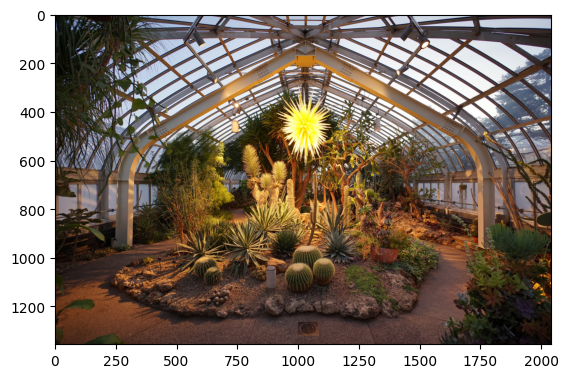

In [ ]:
with open(os.path.join(save_folder,'train_images.json'), 'rt') as f:
    data = json.loads(f.read())

image_path = random.choice(data)
print(image_path)
plt.imshow(plt.imread(image_path))

# 2

In [4]:
seed = 42

def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Thu Oct 10 10:32:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

In [6]:
rgb_weights = torch.FloatTensor([65.481, 128.553, 24.966]).to(device)
imagenet_mean = torch.FloatTensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
imagenet_std = torch.FloatTensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)

In [7]:
def convert_image(img, source, target):
    """
    Convert an image from a source format to a target format.

    :param img: image
    :param source: source format, one of 'pil' (PIL image), '[0, 1]' or '[-1, 1]' (pixel value ranges)
    :param target: target format, one of 'pil' (PIL image), '[0, 255]', '[0, 1]', '[-1, 1]' (pixel value ranges),
                   'imagenet-norm' (pixel values standardized by imagenet mean and std.),
                   'y-channel' (luminance channel Y in the YCbCr color format, used to calculate PSNR and SSIM)
    :return: converted image
    """
    assert source in {'pil', '[0, 1]', '[-1, 1]'}, "Cannot convert from source format %s!" % source
    assert target in {'pil', '[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm',
                      'y-channel'}, "Cannot convert to target format %s!" % target

    # Convert from source to [0, 1]
    if source == 'pil':
        img = FT.to_tensor(img)

    elif source == '[0, 1]':
        pass  # already in [0, 1]

    elif source == '[-1, 1]':
        img = (img + 1.) / 2.

    # Convert from [0, 1] to target
    if target == 'pil':
        img = FT.to_pil_image(img)

    elif target == '[0, 255]':
        img = 255. * img

    elif target == '[0, 1]':
        pass  # already in [0, 1]

    elif target == '[-1, 1]':
        img = 2. * img - 1.

    elif target == 'imagenet-norm':
        if img.ndimension() == 3:
            img = (img - imagenet_mean) / imagenet_std
        elif img.ndimension() == 4:
            img = (img - imagenet_mean_cuda) / imagenet_std_cuda

    elif target == 'y-channel':
        # Based on definitions at https://github.com/xinntao/BasicSR/wiki/Color-conversion-in-SR
        # torch.dot() does not work the same way as numpy.dot()
        # So, use torch.matmul() to find the dot product between the last dimension of an 4-D tensor and a 1-D tensor
        img = torch.matmul(255. * img.permute(1, 2, 0)[4:-4, 4:-4, :], rgb_weights) / 255. + 16.

    return img

In [8]:
class ImageTransforms(object):

    def __init__(self, crop_size, scaling_factor, lr_img_type, hr_img_type, augments=False):
        self.augments = augments
        self.crop_size = crop_size
        self.scaling_factor = scaling_factor
        self.lr_img_type = lr_img_type
        self.hr_img_type = hr_img_type

    def __call__(self, img):
        left = random.randint(1, img.width - self.crop_size)
        top = random.randint(1, img.height - self.crop_size)
        right = left + self.crop_size
        bottom = top + self.crop_size
        hr_img = img.crop((left, top, right, bottom))

        if self.augments['rotation']:
            hr_img = hr_img.rotate(random.randint(0, 3)*90)

        if self.augments['hflip']:
            if random.randint(0,1):
                hr_img = hr_img.transpose(Image.FLIP_LEFT_RIGHT)

        lr_img = hr_img.resize((int(hr_img.width / self.scaling_factor), int(hr_img.height / self.scaling_factor)),
                                   Image.BICUBIC)

        assert hr_img.width == lr_img.width * self.scaling_factor and hr_img.height == lr_img.height * self.scaling_factor

        lr_img = convert_image(lr_img, source='pil', target=self.lr_img_type)
        hr_img = convert_image(hr_img, source='pil', target=self.hr_img_type)

        return lr_img, hr_img

In [9]:
class SRDataset(Dataset):
    """
    Кастомный датасет, который будет использоваться в DataLoader PyTorch-а.
    """

    def __init__(self, crop_size, scaling_factor, lr_img_type, hr_img_type, mode='train',
                 augments={'rotation': False, 'hflip': False}, data_name=None):
        self.augments = augments
        self.crop_size = int(crop_size)
        self.scaling_factor = int(scaling_factor)
        self.lr_img_type = lr_img_type
        self.hr_img_type = hr_img_type
        self.data_name = data_name
        self.mode = mode

        # Read list of image-paths
        if self.mode == 'test':
            self.images = []
            for dataset in self.data_name:
                with open(dataset, 'r') as j:
                    self.images += json.load(j)
        else:
            with open(self.data_name, 'r') as j:
                self.images = json.load(j)

        # Select the correct set of transforms
        if self.mode == 'train':
            assert lr_img_type in {'[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm'}
            assert hr_img_type in {'[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm'}

            assert self.crop_size % self.scaling_factor == 0, "Crop dimensions are not perfectly divisible by scaling factor! This will lead to a mismatch in the dimensions of the original HR patches and their super-resolved (SR) versions!"

            self.transform = ImageTransforms(crop_size=self.crop_size,
                                            scaling_factor=self.scaling_factor,
                                            lr_img_type=self.lr_img_type,
                                            hr_img_type=self.hr_img_type,
                                            augments=self.augments)
        else:
            self.transform_to_hr = transforms.Compose([
                transforms.Resize(size=(self.crop_size, self.crop_size),
                                  interpolation=Image.BICUBIC),
                transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            self.transform_to_lr = transforms.Compose([
                transforms.Resize(size=(self.crop_size//self.scaling_factor,
                                        self.crop_size//self.scaling_factor),
                                  interpolation=Image.BICUBIC),
                transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __getitem__(self, i):
        img = Image.open(self.images[i], mode='r')
        img = img.convert('RGB')
        if self.mode == 'train':
            lr_img, hr_img = self.transform(img)

            return lr_img, hr_img
        else:
            return self.transform_to_lr(img), self.transform_to_hr(img)

    def __len__(self):
        return len(self.images)

In [10]:
# параметры датасета
# аугментация изображений (повороты и отражение по горизонтали): позволяет разнообразить изображения в датасете
augments = {
    'rotation': False,  # поворот на 90, 180 или 270 градусов
    'hflip' : True      # отражение по горизонтали
}
crop_size = 256 # размер обрезки целевого hr изображения
lr_img_type = 'imagenet-norm' # тип, к которому приводим lr изображение
hr_img_type = '[-1, 1]' # тип, к которому приводим hr изображение
train_data_name = '/content/jsons/train_images.json' # путь к json, полученному на стадии подготовки датасета
val_data_name = '/content/jsons/DIV2K_valid_HR_test_images.json'
test_data_name = ['/content/jsons/original_set5_test_images.json',
                  '/content/jsons/original_set14_test_images.json']

# параметры обучения модели
save_every = 20 # сохранять модель каждые save_every эпох
print_every = 140 # количество итераций для вывода статистики
start_epoch = 0 # начальная эпоха
iters = 2e5 # общее количество итераций
batch_size = 24 # размер батча
lr = 2e-4 # скорость обучения
workers = 1

# параметры структуры модели
upscale_factor = 2 # во сколько раз увеличиваем размер изображения
n_blocks = 16 # кол-во residual блоков в моделе

In [11]:
class Data(pl.LightningDataModule):
    def __init__(self, train_data_name, val_data_name, test_data_name, crop_size,
                 upscale_factor, lr_img_type, hr_img_type, augments, num_workers=0,
                 batch_size=16):
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size

        self.train_dataset = SRDataset(crop_size=crop_size, scaling_factor=upscale_factor,
                                  lr_img_type=lr_img_type, hr_img_type=hr_img_type, mode='train',
                                  data_name=train_data_name, augments=augments)
        self.val_dataset = SRDataset(crop_size=crop_size, scaling_factor=upscale_factor,
                                lr_img_type=None, hr_img_type=None, mode='val',
                                data_name=val_data_name, augments=None)
        self.test_dataset = SRDataset(crop_size=crop_size, scaling_factor=upscale_factor,
                                lr_img_type=None, hr_img_type=None, mode='test',
                                data_name=test_data_name, augments=None)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            drop_last=True,
            pin_memory=torch.cuda.is_available()
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )

seed_torch(seed)
data_module = Data(train_data_name, val_data_name, test_data_name, crop_size,
                   upscale_factor, lr_img_type, hr_img_type, augments)
x, y = next(iter(data_module.test_dataloader()))  # Test loader.

torch.Size([16, 3, 128, 128]) torch.Size([16, 3, 256, 256])


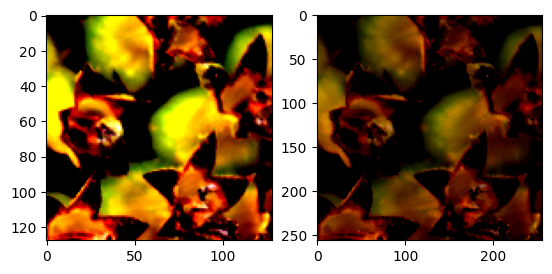

In [ ]:
for batch in data_module.train_dataloader():
    print(batch[0].shape, batch[1].shape)
    plt.subplot(1, 2, 1)
    plt.imshow(batch[0][0].permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(batch[1][0].permute(1, 2, 0))
    break

torch.Size([16, 3, 128, 128]) torch.Size([16, 3, 256, 256])


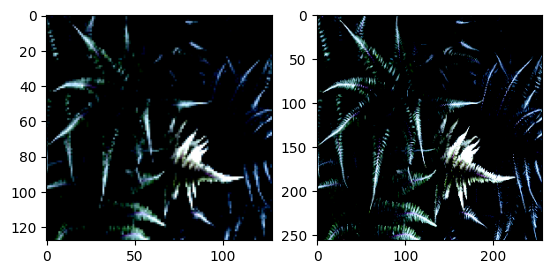

In [ ]:
for batch in data_module.val_dataloader():
    print(batch[0].shape, batch[1].shape)
    plt.subplot(1, 2, 1)
    plt.imshow(batch[0][0].permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(batch[1][0].permute(1, 2, 0))
    break

torch.Size([16, 3, 128, 128]) torch.Size([16, 3, 256, 256])


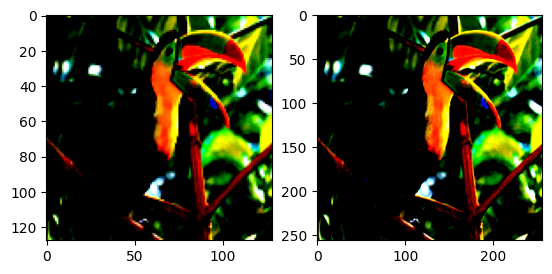

In [ ]:
for batch in data_module.test_dataloader():
    print(batch[0].shape, batch[1].shape)
    plt.subplot(1, 2, 1)
    plt.imshow(batch[0][0].permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(batch[1][0].permute(1, 2, 0))
    break

In [12]:
class ConvolutionalBlock(nn.Module):
    """
    Сверточный блок, который содержит сверточный слой, batch-norm слой и активацию
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh', 'relu'}

        layers = list()

        # добавляем сверточный слой
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # батч-нормализация
        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        # Функция активации
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())
        elif activation == 'relu':
            layers.append(nn.ReLU())

        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        output = self.conv_block(input)

        return output

In [13]:
class ResidualBlock(nn.Module):
    """
    residual block - два сверточных блока со skip connection через них
    """

    def __init__(self, kernel_size=3, n_channels=64):
        super(ResidualBlock, self).__init__()

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation='PReLu')

        # The second convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

    def forward(self, input):
        residual = input
        output = self.conv_block1(input)
        output = self.conv_block2(output)
        output = output + residual

        return output

In [14]:
class InterpolateUpsampleBlock(nn.Module):

    def __init__(self, n_channels: int, kernel_size: int=3, stride: int=1, padding: int=1):
        super(InterpolateUpsampleBlock, self).__init__()

        self.conv = nn.Conv2d(n_channels, n_channels, kernel_size=kernel_size,
                            stride=stride, padding=padding)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.leaky_relu(self.conv(F.interpolate(input, scale_factor=2, mode="bilinear", align_corners=True)), 0.2, True)

In [15]:
class Generator(nn.Module):
    """
    https://arxiv.org/pdf/1609.04802.pdf
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        super(Generator, self).__init__()

        assert type(scaling_factor) is int and scaling_factor in [2, 4, 8]

        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        n_upsample_blocks = int(math.log2(scaling_factor))
        self.upsample_blocks = nn.Sequential(
            *[InterpolateUpsampleBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i
              in range(n_upsample_blocks)])

        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=3, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='Tanh')

    def forward(self, lr_imgs):
        output = self.conv_block1(lr_imgs)
        residual = output
        output = self.residual_blocks(output)
        output = self.conv_block2(output)
        output = output + residual
        output = self.upsample_blocks(output)
        sr_imgs = self.conv_block3(output)

        return sr_imgs

In [16]:
class GeneratorModule(pl.LightningModule):
    def __init__(self, model, loss):
        super().__init__()
        self.model = model
        self.loss = loss
        self.epoch_for_checkpoint = None

        self.best_lpips = float("inf")

        self.random_batch_idx = None

    def forward(self, lr):
        return self.model(lr)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=2e-4, amsgrad=True)
        # self.lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer,
        #                                                       lr_lambda=cosine_annealing_with_warmup_and_restarts)
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer,
                                                                   gamma=0.5)

        return {'optimizer': self.optimizer , 'lr_scheduler': {
            'scheduler': self.lr_scheduler, 'interval': 'epoch'}
            }


    def on_fit_start(self):
        self.train_dl = self.trainer.datamodule.train_dataloader()
        self.val_dl = self.trainer.datamodule.val_dataloader()
        self.test_dl = self.trainer.datamodule.test_dataloader()

    def on_validation_epoch_start(self):
        self.random_batch_idx = random.randint(0, len(self.val_dl)-1)
        self.hr_images = []
        self.sr_images = []

    def common_step(self, batch, batch_idx, split="train", eps=1e-8):
        lr, hr = batch
        sr = self(lr)
        loss = self.loss(sr, hr)
        psnr_values = []
        ssim_values = []
        lpips_values = []
        if split == "val":
            for img_hr, img_sr in zip(hr, sr):
                norm_img_sr = (img_sr - img_sr.min() + eps) / (img_sr.max() - img_sr.min() + eps)
                sr_img = convert_image(norm_img_sr, source='[0, 1]', target='pil')
                norm_img_hr = (img_hr - img_hr.min() + eps) / (img_hr.max() - img_hr.min() + eps)
                if batch_idx == self.random_batch_idx:
                    self.hr_images.append(norm_img_hr.permute(1, 2, 0).cpu().detach())
                    self.sr_images.append(torch.tensor(np.array(sr_img)).cpu().detach())
                norm_img_hr_np = norm_img_hr.permute(1, 2, 0).cpu().detach().numpy()
                norm_img_sr_np = norm_img_sr.permute(1, 2, 0).cpu().detach().numpy()
                hr_y = convert_image(norm_img_hr, source='[0, 1]', target='y-channel')
                sr_y = convert_image(norm_img_sr, source='[0, 1]', target='y-channel')
                psnr = peak_signal_noise_ratio(norm_img_hr_np, norm_img_sr_np, data_range=255.)
                ssim = structural_similarity(hr_y.cpu().detach().numpy(),
                                             sr_y.cpu().detach().numpy(),
                                             data_range=255.) # , multichannel=True, channel_axis=-1

                dist = lpips(norm_img_hr, norm_img_sr)
                lpips_score = dist.item()
                psnr_values.append(psnr)
                ssim_values.append(ssim)
                lpips_values.append(lpips_score)

            if batch_idx == self.random_batch_idx:
                self.hr_images = torch.stack(self.hr_images, dim=0)
                self.sr_images = torch.stack(self.sr_images, dim=0)

            self.log(f"{split}_loss", round(loss.item(), 4), prog_bar=True)
            self.log(f"{split}_PSNR_score", round(np.mean(psnr_values), 4), prog_bar=True)
            self.log(f"{split}_SSim_score", round(np.mean(ssim_values), 4), prog_bar=True)
            self.log(f"{split}_LPIPS_score", round(np.mean(lpips_values), 4), prog_bar=True)

            return {
                'loss': loss,
                'psnr': np.mean(psnr_values),
                'ssim': np.mean(ssim_values),
                'lpips': np.mean(lpips_values)
            }
        else:
            self.log(f"{split}_loss", round(loss.item(), 4), prog_bar=True)
            self.log("learning_rate", self.optimizer.state_dict()['param_groups'][0]['lr'])

            return {
                'loss': loss
            }

    def training_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            return self.common_step(batch, batch_idx, split="val")

    def on_train_epoch_end(self):
        wandb.log({"LR": self.optimizer.state_dict()['param_groups'][0]['lr']})
        self.lr_scheduler.step()

    def on_validation_epoch_end(self):
        mean_loss = self.trainer.logged_metrics.get('val_loss')
        mean_psnr = self.trainer.logged_metrics.get('val_PSNR_score')
        mean_ssim = self.trainer.logged_metrics.get('val_SSim_score')
        mean_lpips = self.trainer.logged_metrics.get('val_LPIPS_score')

        if not trainer.sanity_checking:
            if self.best_lpips > mean_lpips:
                self.best_lpips = mean_lpips
                torch.save(self.model.state_dict(),
                          f"/content/weights/SRResNet_best_weights.pth")
                print("Save best weights")
                artifact = wandb.Artifact('model', type='model')
                artifact.add_file(f'/content/weights/SRResNet_best_weights.pth')
                wandb.log_artifact(artifact)
            elif(self.current_epoch + 1) % save_every == 0:
                torch.save(self.model.state_dict(),
                          f"/content/weights/SRResNet_epoch_{(self.current_epoch + 1)}.pth")

            gt = self.hr_images
            gen = self.sr_images
            log_some_samples(gt, gen)

    def on_batch_end(self, trainer, pl_batch, batch_idx, dataloader_idx):
        if self.current_epoch == 0 and self.checkpoint is not None:
            self.current_epoch = self.checkpoint['epoch']
        self.current_epoch += 1

    def on_save_checkpoint(self, checkpoint):
        checkpoint['epoch'] = self.epoch_for_checkpoint
        epoch = self.epoch_for_checkpoint
        checkpoint_filename = f'my_model_epoch_{epoch}.ckpt'
        torch.save(checkpoint, checkpoint_filename)
        artifact = wandb.Artifact('checkpoint', type='model')
        artifact.add_file(checkpoint_filename)
        wandb.log_artifact(artifact)
        print("Save checkpoint")

    def on_load_checkpoint(self, checkpoint):
        self.epoch_for_checkpoint = checkpoint['epoch']

    @classmethod
    def load_from_checkpoint(cls, checkpoint_path, model, loss):
        generator = cls(model, loss)
        generator.load_state_dict(torch.load(checkpoint_path)['state_dict'])
        return generator

In [17]:
class CustomProgressBar(TQDMProgressBar):
    def __init__(self, checkpoint_epoch=None):
        super().__init__()
        self.bar_format = "{l_bar}{bar:10}{r_bar}{bar:-10b}"
        self.checkpoint_epoch = checkpoint_epoch
        if self.checkpoint_epoch is not None:
            self.epoch = self.checkpoint_epoch + 1

    @rank_zero_only
    def on_train_epoch_start(self, trainer, pl_module):
        clear_output(wait=True)
        pl_module.epoch_for_checkpoint = self.epoch
        self.train_progress_bar = tqdm(
            total=len(data_module.train_dataloader()),
            desc=f'Epoch: {self.epoch}/{trainer.max_epochs}',
            bar_format=self.bar_format,
            position=0,
            leave=True,
        )

    def on_validation_epoch_start(self, trainer, pl_module):
        self.val_progress_bar = tqdm(
            total=len(data_module.val_dataloader()),
            desc=f'Validation',
            bar_format=self.bar_format,
            position=0,
            leave=True,
        )

    @rank_zero_only
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Обновление прогресс-бара после каждого батча
        loss = outputs['loss'].item()

        self.train_progress_bar.set_postfix({
            'train_loss': f'{loss:.4f}'
        })
        self.train_progress_bar.update(1)

    @rank_zero_only
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Обновление прогресс-бара после каждого батча
        loss = outputs['loss'].item()
        psnr = outputs['psnr']
        ssim = outputs['ssim']
        lpips = outputs['lpips']
        self.val_progress_bar.set_postfix({
            'val_loss': f'{loss:.4f}',
            'val_PSNR_score': f'{psnr:.4f}',
            'val_SSim_score': f'{ssim:.4f}',
            'val_LPIPS_score': f'{lpips:.4f}'
        })
        self.val_progress_bar.update(1)

    @rank_zero_only
    def on_validation_epoch_end(self, trainer, pl_module):
        if not trainer.sanity_checking:
            self.train_progress_bar.close()
            self.val_progress_bar.close()
            self.epoch += 1

In [18]:
def log_some_samples(gt, gen):

    if len(gt) <= 5:
        num_s = len(gt)
    else:
        num_s = 5

    plt.figure(figsize=(15, 9))
    for k in range(num_s):
        plt.subplot(2, num_s, k + 1)
        plt.imshow(gt[k])
        plt.axis("off")
        plt.title('High Resolution')

        plt.subplot(2, num_s, (k + 1) + num_s)
        plt.imshow(gen[k])
        plt.axis("off")
        plt.title('Result image')

    plt.tight_layout()

    buffer = BytesIO()
    plt.savefig(buffer, format='jpg')
    buffer.seek(0)
    shap_img = buffer.getvalue()
    buffer.close()
    img_bytes = BytesIO(shap_img)
    pil_img = Image.open(img_bytes)
    wandb.log({'some_samples': [wandb.Image(pil_img, caption='some_samples')]})

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('vovan-frolov2011/Single Image Super Resolution/checkpoint:v435', type='model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
seed_torch(seed)
os.makedirs('weights', exist_ok=True)
lpips = LPIPS(net='vgg').to(device)
# generator = Generator(n_blocks=n_blocks, scaling_factor=upscale_factor).to(device)
# generator = GeneratorModule(generator, nn.L1Loss().to(device))

checkpoint_path = "/content/artifacts/checkpoint:v435/my_model_epoch_108.ckpt"
checkpoint = torch.load(checkpoint_path)
generator = GeneratorModule.load_from_checkpoint(checkpoint_path,
                                                 model=Generator(n_blocks=n_blocks, scaling_factor=upscale_factor).to(device),
                                                 loss=nn.L1Loss().to(device))
wandb.init(project="Single Image Super Resolution", name="Generator_pretrain")
current_epoch = int(checkpoint_path.split(".")[0].split("_")[-1])
progress_bar = CustomProgressBar(current_epoch)
trainer = pl.Trainer(max_epochs=int(iters // len(data_module.train_dataloader())),
                     callbacks=[progress_bar, pl.callbacks.ModelCheckpoint(monitor='val_LPIPS_score', mode='min', save_last=True)],
                     check_val_every_n_epoch=1,
                     logger=pl.loggers.WandbLogger(project="Single Image Super Resolution"))
# resume_from_checkpoint="/content/"
# progress_bar.current_epoch = checkpoint['epoch']
trainer.fit(generator, data_module)

Epoch: 194/4000:  60%|██████    | 30/50 [01:10<00:48,  2.42s/it, train_loss=0.0572]

# 3

In [19]:
class PerceptionLoss(nn.Module):
    """
    Класс, который считает MSE между двумя тензорами в пространстве фичей VGG19
    """
    def __init__(self, feature_layer=35):
        super(PerceptionLoss, self).__init__()
        model = vgg19(pretrained=True).to(device)

        self.weights = [0.1, 0.1, 1, 1, 1]
        self.parts = []
        for i in range(5):
            if i == 0:
                part = nn.Sequential(*list(model.features)[:feature_layer//5]).eval()
                for name, param in part.named_parameters():
                    param.requires_grad = False
            elif i == 1:
                part = nn.Sequential(*list(model.features)[feature_layer//5:2*feature_layer//5]).eval()
                for name, param in part.named_parameters():
                    param.requires_grad = False
            elif i == 2:
                part = nn.Sequential(*list(model.features)[2*feature_layer//5:3*feature_layer//5]).eval()
                for name, param in part.named_parameters():
                    param.requires_grad = False
            elif i == 3:
                part = nn.Sequential(*list(model.features)[3*feature_layer//5:4*feature_layer//5]).eval()
                for name, param in part.named_parameters():
                    param.requires_grad = False
            else:
                part = nn.Sequential(*list(model.features)[4*feature_layer//5:5*feature_layer//5]).eval()
                for name, param in part.named_parameters():
                    param.requires_grad = False
            self.parts.append(part)

        # self.cluster1 = nn.Sequential(
        #     nn.Conv2d(1920, 2, (1, 1))
        # )
        # self.cluster2 = nn.Sequential(
        #     nn.Conv2d(1920, 1920, (1, 1)),
        #     nn.ReLU(),
        #     nn.Conv2d(1920, 2, (1, 1))
        # )
        # self.dropout = nn.Dropout2d(p=0.1)
        self.fc = nn.Linear(1920*16*16, 2)
        self.dropout = nn.Dropout1d(p=0.1)

    def forward(self, input, target):
        inputs, targets = [], []
        for i, part in enumerate(self.parts):
            input, target = part(input), part(target)
            if input.shape[-1] != 16:
                input = F.adaptive_avg_pool2d(input, (16, 16))
                target = F.adaptive_avg_pool2d(target, (16, 16))
            inputs.append(input*self.weights[i])
            targets.append(target*self.weights[i])

        # out_i, out_t = torch.cat(inputs, dim=1), torch.cat(targets, dim=1)
        # code_inp = self.cluster1(self.dropout(out_i))
        # code_target = self.cluster1(self.dropout(out_t))
        # code_inp += self.cluster2(self.dropout(out_i))
        # code_target += self.cluster2(self.dropout(out_t))

        # input, target = torch.sigmoid(code_inp), torch.sigmoid(code_target)
        out_i, out_t = torch.cat(inputs, dim=1).view(input.size(0), -1), torch.cat(targets, dim=1).view(target.size(0), -1)
        input, target = torch.sigmoid(self.fc(self.dropout(out_i))), torch.sigmoid(self.fc(self.dropout(out_t)))
        perception_loss = F.mse_loss(input, target)

        return perception_loss

In [20]:
class Discriminator(nn.Module):
    """
    https://arxiv.org/pdf/1609.04802.pdf
    """

    def __init__(self, kernel_size=3, n_channels=64, n_blocks=8, fc_size=1024):
        super(Discriminator, self).__init__()

        in_channels = 3

        conv_blocks = list()
        for i in range(n_blocks):
            out_channels = (n_channels if i == 0 else in_channels * 2) if i % 2 == 0 else in_channels
            conv_blocks.append(
                ConvolutionalBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=1 if i % 2 == 0 else 2, batch_norm=i != 0, activation='LeakyReLu'))
            in_channels = out_channels
        self.conv_blocks = nn.Sequential(*conv_blocks)

        # адаптивный пулинг нужен, чтобы выход с последнего сверточного слоя
        # всегда соответствовал одной и той же размерности
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(out_channels * 6 * 6, fc_size)

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.fc2 = nn.Linear(fc_size, 1)

    def forward(self, imgs):
        batch_size = imgs.size(0)
        output = self.conv_blocks(imgs)
        output = self.adaptive_pool(output)
        output = self.fc1(output.view(batch_size, -1))
        output = self.leaky_relu(output)
        logit = self.fc2(output)

        return logit

In [21]:
def linear_warmup(step, warmup_steps) -> float:
    """Linear warmup.

    Function maps current step or epoch to factor of learning rate schedules.
    """
    if warmup_steps > 0:
        return min(1.0, step / warmup_steps)
    else:
        return 1.0


def cosine_annealing_with_warmup_and_restarts(
    step,
    warmup_steps=0,
    cycle_steps=800,
    restarts_factor=1.0,
    decay_rate=0.95,
    bench=200,
    min_scale=0.25
) -> float:
    """Cosine annealing with linear warmup and restarts.

    After the warmup phase, applies cosine annealing decay to min_scale. If the
    decay cycle hasn't ended, the value stays at min_scale. When the cycle ends,
    the value resets to 1.0.
    """
    cycle_length = cycle_steps

    if step <= warmup_steps + cycle_steps:
        if step < warmup_steps:
            return linear_warmup(step, warmup_steps)
        else:
            step_in_cycle = step - warmup_steps
            cosine_decay = 0.5 * (1 + math.cos(math.pi * step_in_cycle / cycle_length))

            if min_scale is None:
                return 1.0 * cosine_decay
            else:
                return min_scale + (1.0 - min_scale) * cosine_decay
    else:
        first_cycle_length = cycle_steps + warmup_steps
        cycle_length = int(first_cycle_length * restarts_factor)
        step_in_cycle = step - first_cycle_length - ((step - first_cycle_length) // cycle_length) * cycle_length
        cosine_decay = 0.5 * (1 + math.cos(math.pi * step_in_cycle / (cycle_length - bench)))

        if min_scale is None:
            return decay_rate**((step - first_cycle_length) // cycle_length + 1) * 1.0 * cosine_decay
        else:
            if step_in_cycle < cycle_length - bench:
                return min_scale + ((1.0 - min_scale) * cosine_decay) * decay_rate**((step - first_cycle_length) // cycle_length + 1)
            else:
                return min_scale

In [22]:
# параметры обучения модели
save_every = 1
print_every = 10
start_epoch = 0
iters = 1e5
batch_size = 24
lr = 1e-4
perception_loss_modifier = 1
beta = 0.1 # модификатор adversarial ошибки
l1_modifier = 1
workers = 1

# параметры структуры модели
srresnet_checkpoint = "/content/artifacts/checkpoint:v1481/my_model_epoch_1548.ckpt"
n_blocks = 16

In [23]:
class SRGANModule(pl.LightningModule):
    def __init__(self, generator, discriminator, adversarial_loss, beta, perception_loss,
                 perception_loss_modifier, l1_loss, l1_modifier=1, lr_d=1e-4,
                 lr_g=1e-4):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.adversarial_loss = adversarial_loss
        self.perception_loss = perception_loss
        self.l1 = l1_loss
        self.beta = beta
        self.perception_modifier = perception_loss_modifier
        self.l1_modifier = l1_modifier
        self.lr_d = lr_d
        self.lr_g = lr_g

        self.best_lpips = float("inf")

        self.automatic_optimization = False
        self.random_batch_idx = None
        self.progress_bar = {'refresh_rate': 1}

    def forward(self, lr, hr, split):
        # сначала обрабатываем дискриминатор
        sr = self.generator(lr)
        hr_labels = self.discriminator(hr)
        fake_labels = self.discriminator(sr.detach())
        # hr_labels = torch.sigmoid(hr_labels)
        # fake_labels = torch.sigmoid(fake_labels)

        # Binary Cross-Entropy loss
        a = torch.zeros_like(fake_labels)
        b = torch.ones_like(hr_labels)
        smooth = np.random.uniform(0.01, 0.1)
        d_loss = self.adversarial_loss(fake_labels, torch.empty_like(a).uniform_(0.0, smooth)) + \
            self.adversarial_loss(hr_labels, torch.empty_like(b).uniform_(1.0-smooth, 1.0))

        if split == "train":
            # back propagation
            d_loss.backward()
            self.optimizer_d.step()
            # wandb.log({"Dis_LR": self.optimizer_d.state_dict()['param_groups'][0]['lr']})
            # self.lr_scheduler_d.step()

        # затем получаем fake high res изображения
        sr = self.generator(lr)
        # предсказания дискриминатора на фейковых изображениях
        fake_labels = self.discriminator(sr)
        # fale_labels = torch.sigmoid(fake_labels)
        # считаем loss-ы
        perception_loss = self.perception_modifier * self.perception_loss(sr, hr.detach())
        adversarial_loss = self.beta * self.adversarial_loss(fake_labels, torch.ones_like(fake_labels))
        l1_loss = self.l1_modifier * self.l1(sr, hr.detach())
        g_loss = perception_loss + adversarial_loss + l1_loss

        if split == "train":
            # back propagation
            g_loss.backward()
            self.optimizer_g.step()
            # wandb.log({"Gen_LR": self.optimizer_g.state_dict()['param_groups'][0]['lr']})
            # self.lr_scheduler_g.step()

        return d_loss, g_loss, sr

    def configure_optimizers(self):
        self.optimizer_d = torch.optim.Adam(self.parameters(), lr=self.lr_d)
        self.lr_scheduler_d = torch.optim.lr_scheduler.ExponentialLR(self.optimizer_d, gamma=0.99)
        # self.lr_scheduler_d = torch.optim.lr_scheduler.LambdaLR(self.optimizer_d,
        #                                                       lr_lambda=cosine_annealing_with_warmup_and_restarts)
        self.optimizer_g = torch.optim.Adam(self.parameters(), lr=self.lr_g)
        self.lr_scheduler_g = torch.optim.lr_scheduler.ExponentialLR(self.optimizer_g, gamma=0.99)
        # self.lr_scheduler_g = torch.optim.lr_scheduler.LambdaLR(self.optimizer_g,
        #                                                       lr_lambda=cosine_annealing_with_warmup_and_restarts)

        return (
            {'optimizer': self.optimizer_d,
             'lr_scheduler': {
                'scheduler': self.lr_scheduler_d, 'interval': 'step'
                }
                  # 'scheduler': self.lr_scheduler_d, 'interval': 'epoch'
                  # }
             },
            {'optimizer': self.optimizer_g,
             'lr_scheduler': {
                'scheduler': self.lr_scheduler_g, 'interval': 'step'
                }
                  # 'scheduler': self.lr_scheduler_g, 'interval': 'epoch'
                  # }
             }
            )

    def on_fit_start(self):
        self.train_dl = self.trainer.datamodule.train_dataloader()
        self.val_dl = self.trainer.datamodule.val_dataloader()
        self.test_dl = self.trainer.datamodule.test_dataloader()

    def on_validation_epoch_start(self):
        self.random_batch_idx = random.randint(0, len(self.val_dl)-1)
        self.hr_images = []
        self.sr_images = []

    def common_step(self, batch, batch_idx, split="train", eps=1e-8):
        lr, hr = batch
        d_loss, g_loss, sr = self(lr, hr, split)

        psnr_values = []
        ssim_values = []
        lpips_values = []
        if split == 'val':
            for img_hr, img_sr in zip(hr, sr):
                norm_img_sr = (img_sr - img_sr.min() + eps) / (img_sr.max() - img_sr.min() + eps)
                sr_img = convert_image(norm_img_sr, source='[0, 1]', target='pil')
                norm_img_hr = (img_hr - img_hr.min() + eps) / (img_hr.max() - img_hr.min() + eps)
                if batch_idx == self.random_batch_idx:
                    self.hr_images.append(norm_img_hr.permute(1, 2, 0).cpu().detach())
                    # self.sr_images.append(torch.tensor(np.array(sr_img)).cpu().detach())
                    self.sr_images.append(norm_img_sr.permute(1, 2, 0).cpu().detach())
                norm_img_hr_np = norm_img_hr.permute(1, 2, 0).cpu().detach().numpy()
                norm_img_sr_np = norm_img_sr.permute(1, 2, 0).cpu().detach().numpy()
                hr_y = convert_image(norm_img_hr, source='[0, 1]', target='y-channel')
                sr_y = convert_image(norm_img_sr, source='[0, 1]', target='y-channel')
                psnr = peak_signal_noise_ratio(norm_img_hr_np, norm_img_sr_np, data_range=255.)
                ssim = structural_similarity(hr_y.cpu().detach().numpy(),
                                              sr_y.cpu().detach().numpy(),
                                              data_range=255.) # , multichannel=True, channel_axis=-1

                dist = lpips(norm_img_hr, norm_img_sr)
                lpips_score = dist.item()
                psnr_values.append(psnr)
                ssim_values.append(ssim)
                lpips_values.append(lpips_score)

            if batch_idx == self.random_batch_idx:
                self.hr_images = torch.stack(self.hr_images, dim=0)
                self.sr_images = torch.stack(self.sr_images, dim=0)

            self.log(f"{split}_discriminator_loss", round(d_loss.item(), 4), prog_bar=True)
            self.log(f"{split}_generator_loss", round(g_loss.item(), 4), prog_bar=True)
            self.log(f"{split}_PSNR_score", round(np.mean(psnr_values), 4), prog_bar=True)
            self.log(f"{split}_SSim_score", round(np.mean(ssim_values), 4), prog_bar=True)
            self.log(f"{split}_LPIPS_score", round(np.mean(lpips_values), 4), prog_bar=True)

            return {
                'd_loss': d_loss,
                'g_loss': g_loss,
                'psnr': np.mean(psnr_values),
                'ssim': np.mean(ssim_values),
                'lpips': np.mean(lpips_values)
            }
        else:
            self.log(f"{split}_discriminator_loss", round(d_loss.item(), 4), prog_bar=True)
            self.log(f"{split}_generator_loss", round(g_loss.item(), 4), prog_bar=True)
            return {
                'd_loss': d_loss,
                'g_loss': g_loss
            }

    def training_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            return self.common_step(batch, batch_idx, split="val")

    def on_train_epoch_end(self):
        wandb.log({"Dis_LR": self.optimizer_d.state_dict()['param_groups'][0]['lr']})
        self.lr_scheduler_d.step()
        wandb.log({"Gen_LR": self.optimizer_g.state_dict()['param_groups'][0]['lr']})
        self.lr_scheduler_g.step()

    def on_validation_epoch_end(self):
        mean_lpips = self.trainer.logged_metrics.get('val_LPIPS_score')

        if not trainer.sanity_checking:

            if self.best_lpips > mean_lpips:
                self.best_lpips = mean_lpips
                torch.save(self.generator.state_dict(),
                          f"/content/weights/Gen_best_weights.pth")
                torch.save(self.discriminator.state_dict(),
                           f"/content/weights/Dis_best_weights.pth")
                print("Save best weights")
                artifact = wandb.Artifact('model', type='model')
                artifact.add_file(f'/content/weights/Gen_best_weights.pth')
                artifact.add_file(f'/content/weights/Dis_best_weights.pth')
                wandb.log_artifact(artifact)
            elif(self.current_epoch + 1) % save_every == 0:
                torch.save(self.generator.state_dict(),
                          f"/content/weights/Gen_epoch_{(self.current_epoch + 1)}.pth")
                torch.save(self.discriminator.state_dict(),
                          f"/content/weights/Dis_epoch_{(self.current_epoch + 1)}.pth")
                artifact = wandb.Artifact('model', type='model')
                artifact.add_file(f'/content/weights/Gen_epoch_{(self.current_epoch + 1)}.pth')
                artifact.add_file(f'/content/weights/Dis_epoch_{(self.current_epoch + 1)}.pth')
                wandb.log_artifact(artifact)

            gt = self.hr_images
            gen = self.sr_images
            log_some_samples(gt, gen)

    def on_batch_end(self, trainer, pl_batch, batch_idx, dataloader_idx):
        if self.current_epoch == 0 and self.checkpoint is not None:
            self.current_epoch = self.checkpoint['epoch']
        self.current_epoch += 1

    def on_save_checkpoint(self, checkpoint):
        checkpoint['epoch'] = self.epoch_for_checkpoint
        epoch = self.epoch_for_checkpoint
        checkpoint_filename = f'my_model_epoch_{epoch}.ckpt'
        torch.save(checkpoint, checkpoint_filename)
        artifact = wandb.Artifact('checkpoint', type='model')
        artifact.add_file(checkpoint_filename)
        wandb.log_artifact(artifact)
        print("Save checkpoint")

    def on_load_checkpoint(self, checkpoint):
        self.epoch_for_checkpoint = checkpoint['epoch']

    @classmethod
    def load_from_checkpoint(cls, gen_checkpoint_path, dis_checkpoint_path,
                             generator, discriminator, adversarial_loss, beta,
                             perception_loss, perception_loss_modifier, l1_loss,
                             l1_modifier):
        generator.load_state_dict(torch.load(gen_checkpoint_path)['state_dict'])
        if dis_checkpoint_path is not None:
            discriminator.load_state_dict(torch.load(dis_checkpoint_path)['state_dict'])
        model = cls(generator, discriminator, adversarial_loss, beta,
                    perception_loss, perception_loss_modifier, l1_loss,
                    l1_modifier)

        return generator

In [24]:
class CustomProgressBar(TQDMProgressBar):
    def __init__(self, checkpoint_epoch=None):
        super().__init__()
        self.bar_format = "{l_bar}{bar:10}{r_bar}{bar:-10b}"
        self.checkpoint_epoch = checkpoint_epoch
        if self.checkpoint_epoch is not None:
            self.epoch = self.checkpoint_epoch + 1
        else:
            self.epoch = None

    @rank_zero_only
    def on_train_epoch_start(self, trainer, pl_module):
        clear_output(wait=True)
        if self.epoch is not None:
            pl_module.epoch_for_checkpoint = self.epoch
        self.train_progress_bar = tqdm(
            total=len(data_module.train_dataloader()),
            desc=f'Epoch: {self.epoch}/{trainer.max_epochs}',
            bar_format=self.bar_format,
            position=0,
            leave=True,
        )

    def on_validation_epoch_start(self, trainer, pl_module):
        self.val_progress_bar = tqdm(
            total=len(data_module.val_dataloader()),
            desc=f'Validation',
            bar_format=self.bar_format,
            position=0,
            leave=True,
        )

    @rank_zero_only
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Update the progress bar after each batch
        d_loss = outputs['d_loss'].item()
        g_loss = outputs['g_loss'].item()
        # psnr = outputs['psnr']
        # ssim = outputs['ssim']
        # lpips = outputs['lpips']
        self.train_progress_bar.set_postfix({
            'train_dis_loss': f'{d_loss:.4f}',
            'train_gen_loss': f'{g_loss:.4f}',
            # 'train_PSNR_score': f'{psnr:.4f}',
            # 'train_SSim_score': f'{ssim:.4f}',
            # 'train_LPIPS_score': f'{lpips:.4f}'
        })
        self.train_progress_bar.update(1)

    @rank_zero_only
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Update the progress bar after each batch
        d_loss = outputs['d_loss'].item()
        g_loss = outputs['g_loss'].item()
        psnr = outputs['psnr']
        ssim = outputs['ssim']
        lpips = outputs['lpips']
        self.val_progress_bar.set_postfix({
            'val_dis_loss': f'{d_loss:.4f}',
            'val_gen_loss': f'{g_loss:.4f}',
            'val_PSNR_score': f'{psnr:.4f}',
            'val_SSim_score': f'{ssim:.4f}',
            'val_LPIPS_score': f'{lpips:.4f}'
        })
        self.val_progress_bar.update(1)

    @rank_zero_only
    def on_validation_epoch_end(self, trainer, pl_module):
        if not trainer.sanity_checking:
            self.train_progress_bar.close()
            self.val_progress_bar.close()
            self.epoch += 1

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('vovan-frolov2011/Single Image Super Resolution/model:v203', type='model') # веса с предобучения
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [25]:
import wandb
run = wandb.init()
artifact = run.use_artifact('vovan-frolov2011/Single Image Super Resolution/model:v847', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model:v805, 94.96MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.4


In [26]:
# создаем генератор и дискриминатор
generator = Generator(n_blocks=n_blocks, scaling_factor=upscale_factor).to(device)
# generator.load_state_dict(torch.load("/content/artifacts/model:v203/SRResNet_best_weights.pth")) # инициализируем модель весами srresnet с предобучения
generator.load_state_dict(torch.load("/content/artifacts/model:v847/Gen_epoch_30.pth"))
discriminator = Discriminator().to(device)
discriminator.load_state_dict(torch.load("/content/artifacts/model:v847/Dis_epoch_30.pth"))

# инициализируем loss-ы
perception_criterion = PerceptionLoss().to(device) # MSE в пространстве фичей определённой модели
adversarial_criterion = nn.BCEWithLogitsLoss().to(device)
l1_criterion = nn.L1Loss().to(device)

<ipython-input-26-db09b5dd4177>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/content/artifacts/model:v805/Gen_epoch_32.pth"))
<ipy

In [ ]:
seed_torch(seed)
os.makedirs('weights', exist_ok=True)
lpips = LPIPS(net='vgg').to(device)
# generator = SRGANModule(generator, discriminator, adversarial_criterion, beta,
#                         perception_criterion, perception_loss_modifier,
#                         l1_criterion, l1_modifier)
generator = SRGANModule(generator, discriminator, adversarial_criterion, beta,
                        perception_criterion, perception_loss_modifier,
                        l1_criterion, l1_modifier, 6.3270e-9, 6.3270e-9)
wandb.init(project="Single Image Super Resolution", name="SRGAN_training")
# current_epoch = int(checkpoint_path.split(".")[0].split("_")[-1])
progress_bar = CustomProgressBar(0)
trainer = pl.Trainer(max_epochs=int(iters // len(data_module.train_dataloader())),
                     callbacks=[progress_bar, pl.callbacks.ModelCheckpoint(monitor='val_LPIPS_score', mode='min', save_last=True)],
                     check_val_every_n_epoch=1,
                     logger=pl.loggers.WandbLogger(project="Single Image Super Resolution"))
trainer.fit(generator, data_module)

Epoch: 31/2000:  54%|█████▍    | 27/50 [01:29<01:14,  3.26s/it, train_dis_loss=0.8595, train_gen_loss=0.5184]